In [1]:
# Standard Python modules
import os, sys
import yaml
import glob
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
from ar_funcs import AR_rank
from wrf_preprocess import preprocess_PCPT
import nclcmaps as nclc
from plotter import draw_basemap

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths

path_to_data = '/home/dnash/SEAK_clim_data/'      # project data -- read only
path_to_work = '/work/dnash/SEAK_clim_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [10]:
### TODO: make a yaml dict
ext1 = [-141., -130., 54., 61.] # extent of SEAK 
ext2 = [-180., -110., 19, 80] # extent of CIMSS Plots
## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'center'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']

### Read ERA5 IVT data

In [7]:
datelst = ['1201', '1202']
year = '2020'
filenames = []
for i, monthday in enumerate(datelst):
    filenames.append('/data/downloaded/Reanalysis/ERA5/IVT/{1}/ERA5_IVT_{1}{0}.nc'.format(monthday, year))
    
era = xr.open_mfdataset(filenames, combine='by_coords')

era = era.sel(time='2020-12-01 6:00')
era

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
    time     datetime64[ns] 2020-12-01T06:00:00
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Data variables:
    IVT      (lat, lon) float64 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    uIVT     (lat, lon) float64 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    vIVT     (lat, lon) float64 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    IWV      (lat, lon) float64 dask.array<chunksize=(721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1/0

### Plot IVT and IWV

In [22]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.LambertConformal(central_longitude=-150.0) ## the projection you want your map displayed in
mapcrs = ccrs.PlateCarree()  ## the projection you want your map displayed in


# Set tick/grid locations
lats = era.lat.values
lons = era.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+10,10)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

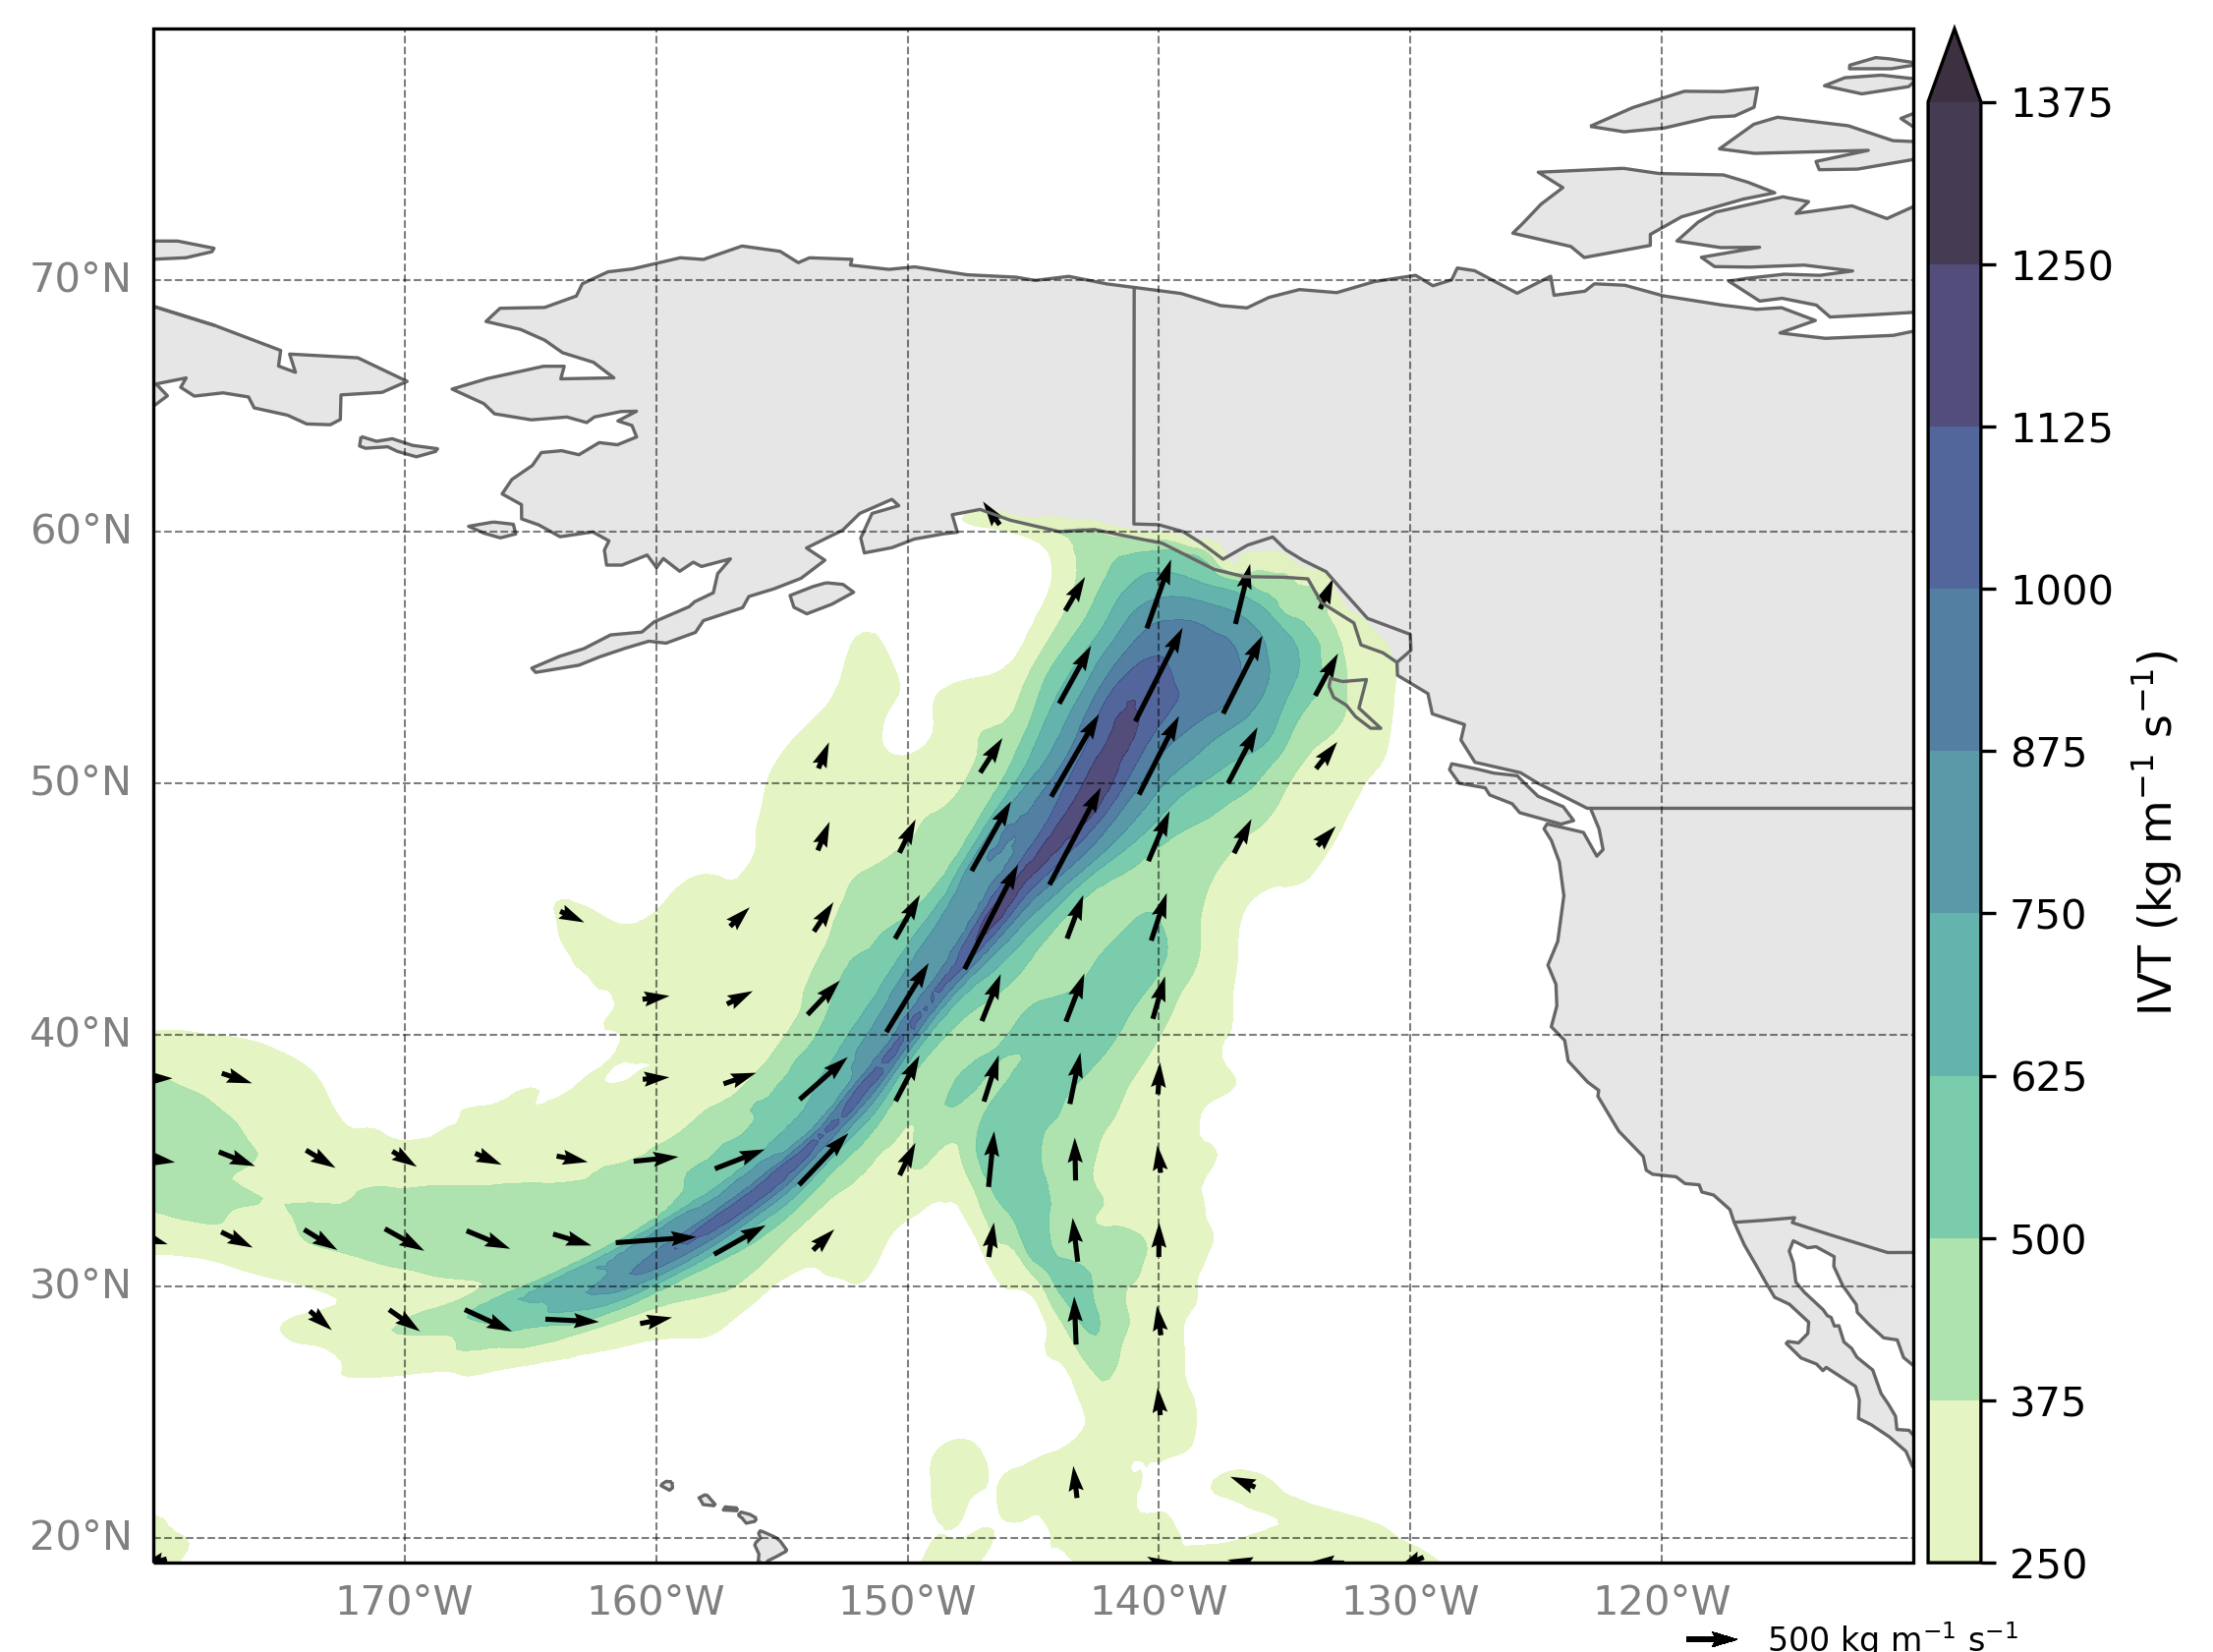

In [27]:
# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'IVT_20201201_06UTC'
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,left_lats=True, right_lats=False, grid=True)

    # Contour Filled
    ivt = era.IVT.values
    clevs = np.arange(250, 1500, 125) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=clevs, cmap=cmap, alpha=0.9, extend='max')
    
    # Wind barbs / vectors 
    uvec = era.uIVT.values
    vvec = era.vIVT.values
    uvec_mask = era.uIVT.where((era.IVT >=250.)).values
    vvec_mask = era.vIVT.where((era.IVT >=250.)).values
    
    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
                  color='k', regrid_shape=20, pivot='middle',
                  angles='xy', scale_units='xy', scale=250, units='xy')


# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)

# quiver key
qk = ax.quiverkey(Q, 0.9, -0.05, 500, '500 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

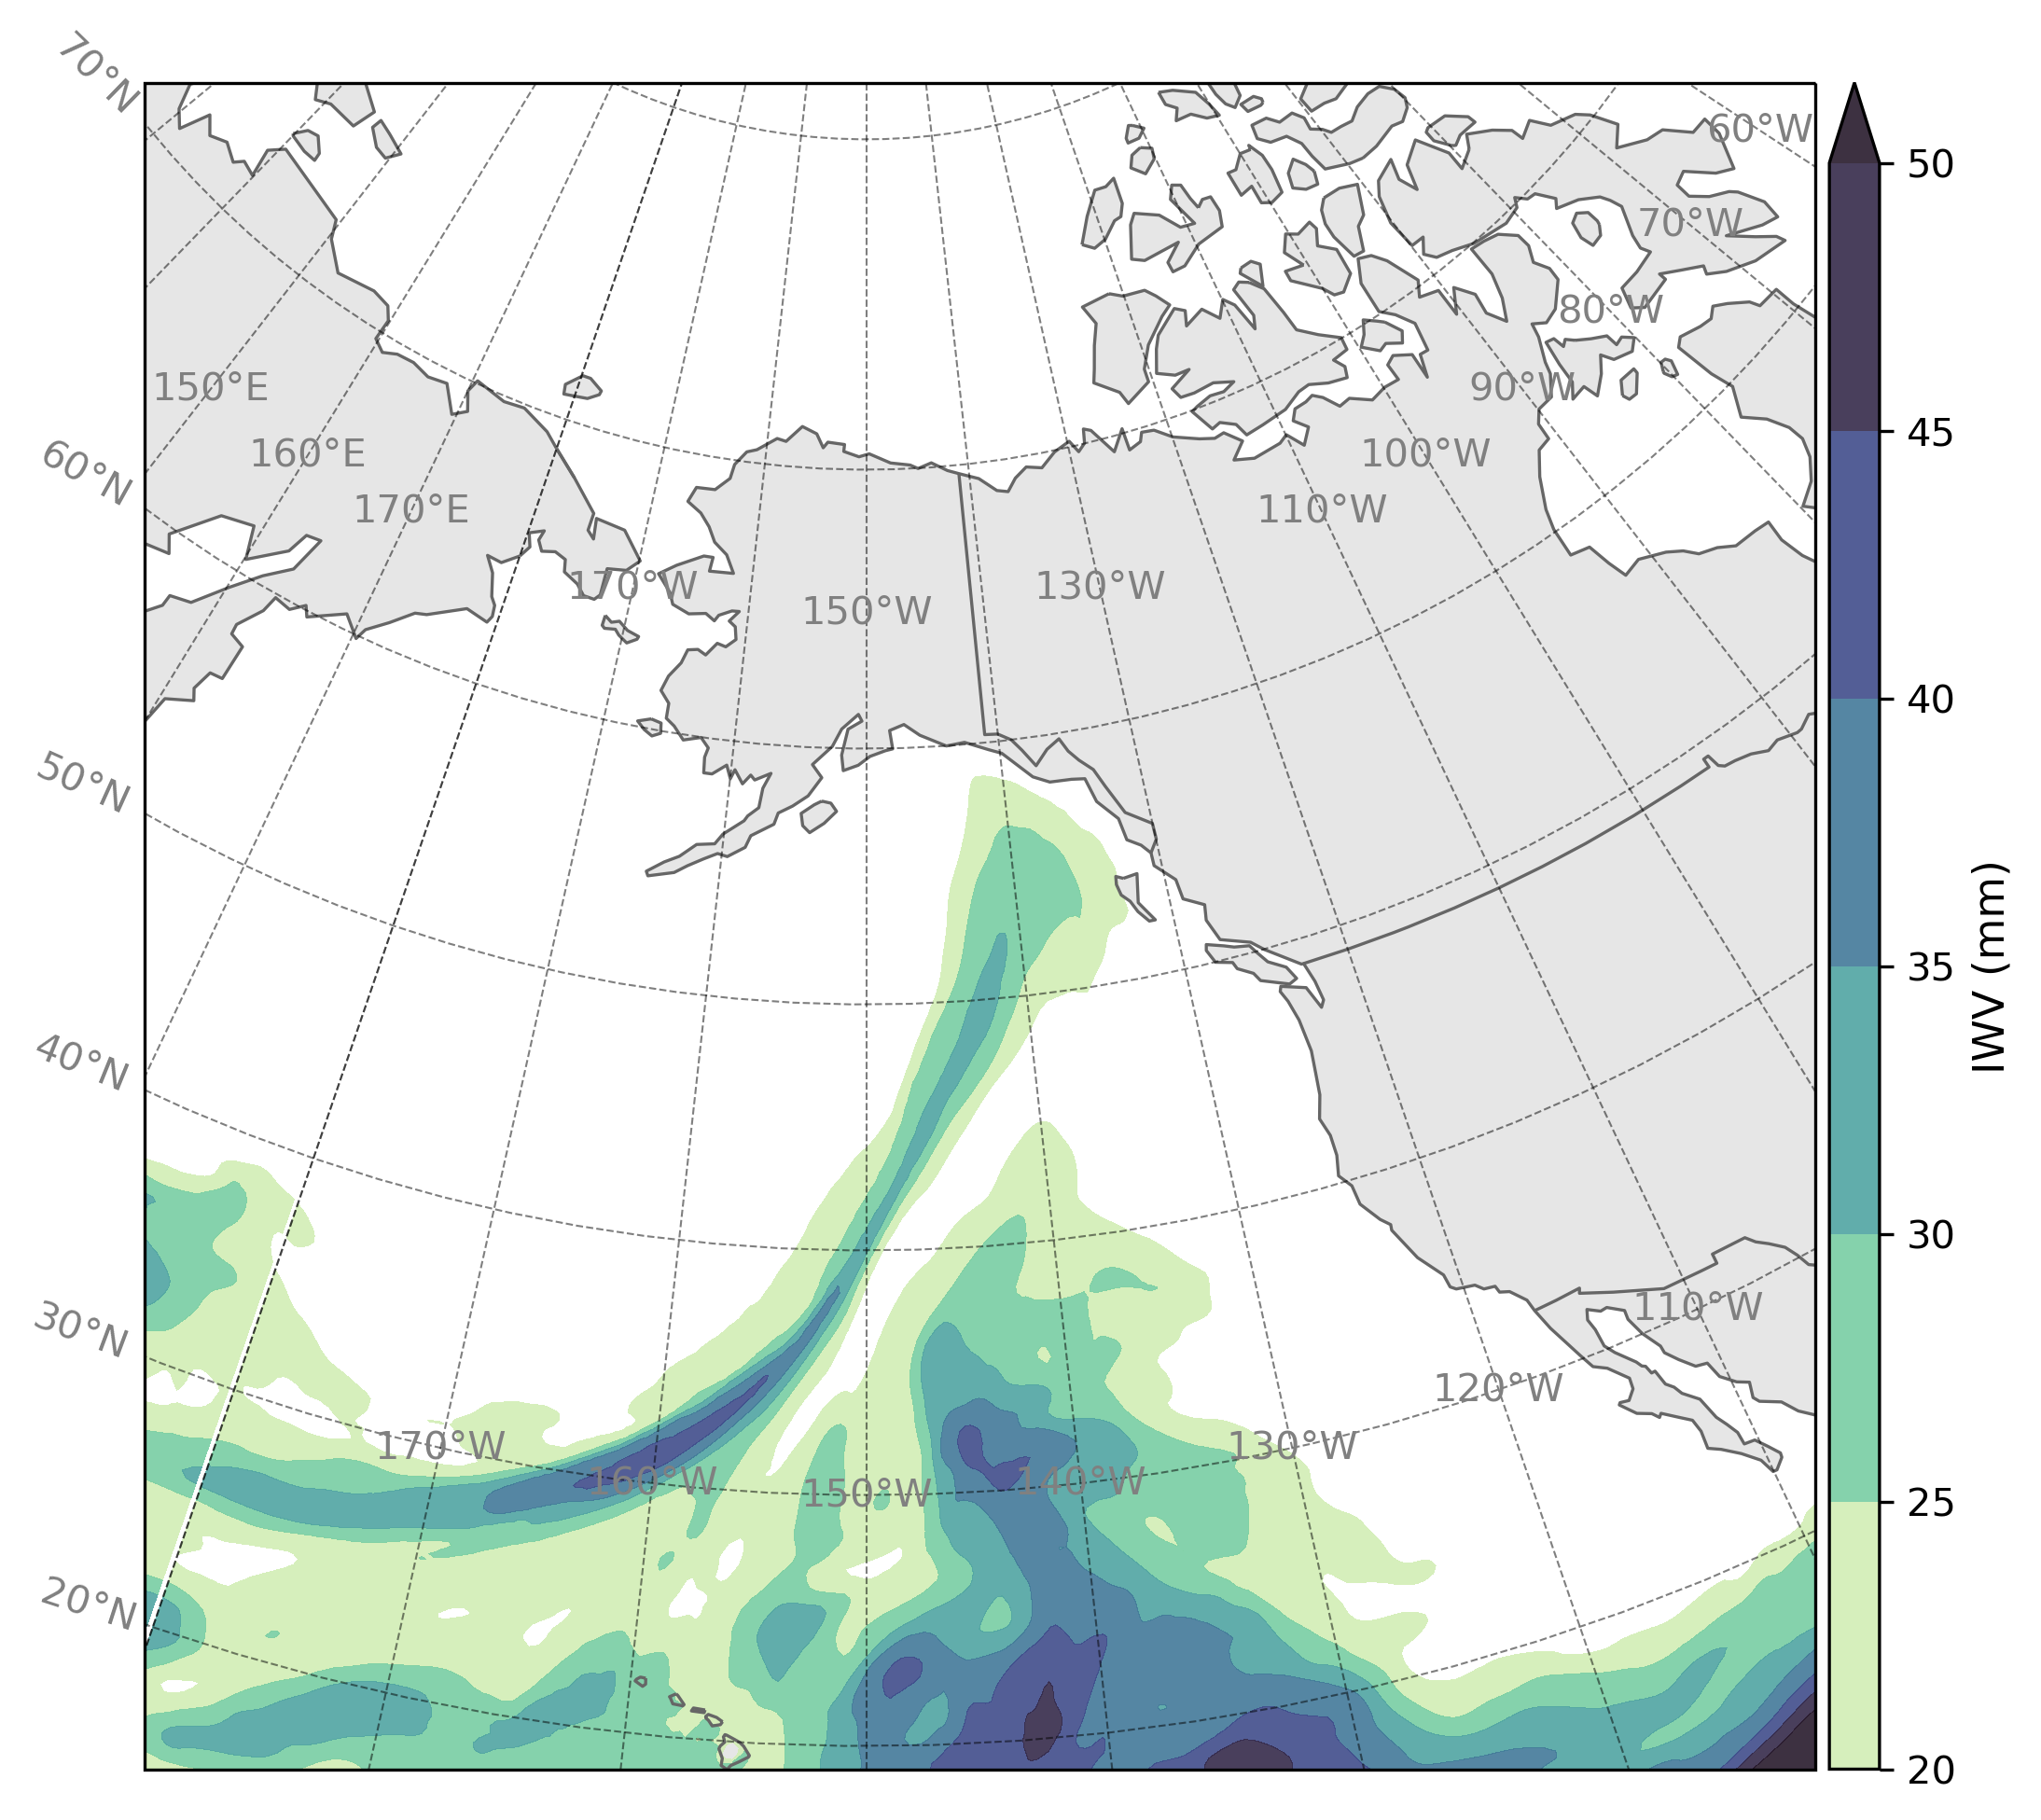

In [17]:
# Create figure
fig = plt.figure(figsize=(8, 4))
fig.dpi = 300
fname = path_to_figs + 'IWV_20201201_06UTC'
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,left_lats=True, right_lats=False, grid=True)

    # Contour Filled
    iwv = era.IWV.values
    clevs = np.arange(20, 55, 5) # levels for IWV
    cmap = cmo.deep # cmap for IWV
    cf = ax.contourf(lons, lats, iwv, transform=datacrs,
                     levels=clevs, cmap=cmap, alpha=0.9, extend='max')


# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label('IWV (mm)', fontsize=11)
cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()